<a href="https://colab.research.google.com/github/dborgesm/Banking-Analytics/blob/master/LGD_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGD Modelling

In [0]:
#Installing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


Loading the data

In [0]:
!gdown https://drive.google.com/uc?id=1w__RrmMJtfdwDH7cMjRpi9IE84po8L0d


Downloading...
From: https://drive.google.com/uc?id=1w__RrmMJtfdwDH7cMjRpi9IE84po8L0d
To: /content/lgd_data.csv
60.5MB [00:00, 166MB/s] 


In [0]:
lgd_data = pd.read_csv('/content/lgd_data.csv')

In [0]:
!pip install scorecardpy

     |████████████████████████████████| 61kB 4.5MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.1.1-cp36-none-any.whl size=58169 sha256=4db86138fec87851d8c995dc04e93224d854221c5a0d66302b097dfa33aaa09d
  Stored in directory: /root/.cache/pip/wheels/8f/4c/98/567ff70984acd88ffae211d8fc209e34b98fb43ff27f09fdd3
Successfully built scorecardpy


In [0]:
import scorecardpy as sc

Converting some variables in categorical because LogisticRegressor does not accept string values


In [0]:
lgd_data.term = lgd_data.term.astype("category")

In [0]:
empl_dic = {"< 1 year":"0", "1 year":"1", "2 years":"2", "3 years":"3",
            "4 years":"4", "5 years":"5", "6 years":"6", "7 years":"7",
            "8 years":"8", "9 years":"9", "10+ years":"10" 
            }
lgd_data["emp_length1"] = lgd_data.emp_length.map(empl_dic)

In [0]:
lgd_data.emp_length1 =lgd_data.emp_length1.astype("category")

In [0]:
lgd_data.drop(["emp_length"], axis=1, inplace=True)

In [0]:
home_dic = {"RENT":"1", "MORTGAGE":"2", "OWN":"3"}
lgd_data["home_status"] = lgd_data.home_ownership.map(home_dic)
lgd_data.home_status = lgd_data.home_status.astype("category")
lgd_data.drop(["home_ownership"], axis=1, inplace=True)

In [0]:
pp_dic = {"n":"0", "y":"1"}
lgd_data["pymnt_plan_cat"] = lgd_data.pymnt_plan.map(pp_dic)
lgd_data.pymnt_plan_cat = lgd_data.pymnt_plan_cat.astype("category")
lgd_data.drop(["pymnt_plan"], axis=1, inplace=True)

In [0]:
purp_dic = {"debt_consolidation":"1", "credit_card":"2", "other":"3", "home_improvement":"4", "liv_leisure_exp":"5"}
lgd_data["purpose_cat"] = lgd_data.purpose.map(purp_dic)
lgd_data.purpose_cat = lgd_data.purpose_cat.astype("category")
lgd_data.drop(["purpose"], axis=1, inplace=True)

In [0]:
ds_dic = {"N":"0", "Y":"1"}
lgd_data["debt_set_plan"] = lgd_data.debt_settlement_flag.map(ds_dic)
lgd_data.debt_set_plan = lgd_data.debt_set_plan.astype("category")
lgd_data.drop(["debt_settlement_flag"], axis=1, inplace=True)

In [0]:
il_dic = {"w":"0", "f":"1"}
lgd_data["init_list_st"] = lgd_data.initial_list_status.map(il_dic)
lgd_data.init_list_st = lgd_data.init_list_st.astype("category")
lgd_data.drop(["initial_list_status"], axis=1, inplace=True)

## Random Forest Regressor


In [0]:
new_index = ["lgd",'term', 'annual_inc', 'zip_code', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'pub_rec', 'revol_bal', 'total_acc', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'mths_since_rcnt_il',
       'il_util', 'open_rv_12m', 'inq_fi', "max_bal_bc", "all_util",
       'total_cu_tl', 'inq_last_12m', 'bc_open_to_buy', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_il_tl', 'num_tl_90g_dpd_24m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'addr_region', 'emp_length1', 'home_status', 'purpose_cat',
       'pymnt_plan_cat', "debt_set_plan"]
len(new_index)
lgd_data = lgd_data[new_index]


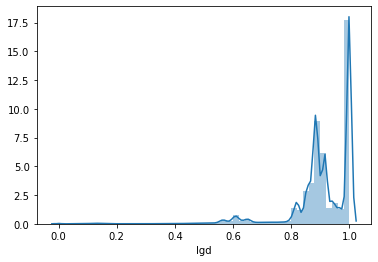

In [0]:
sns.distplot(lgd_data.lgd)

In [0]:
# Same train-test split as before (because of seed!)
lgd_train, lgd_test = sc.split_df(lgd_data, y = "lgd", ratio = 0.7, seed = 251082976).values()

In [0]:
lgd_rf = RandomForestRegressor(n_estimators=1000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. # Wee let it gro as big as it can
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features="auto", # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       )

In [0]:
#Default model 
rf_model = lgd_rf.fit(lgd_train.iloc[:, 1:], lgd_train['lgd'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.0min finished


In [0]:
# Model 2, max_features = 10
lgd_rf2 = RandomForestRegressor(n_estimators=1000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. # Wee let it gro as big as it can
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=10, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       )

In [0]:
#Model 2
rf_model2 = lgd_rf2.fit(lgd_train.iloc[:, 1:], lgd_train['lgd'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.1min finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


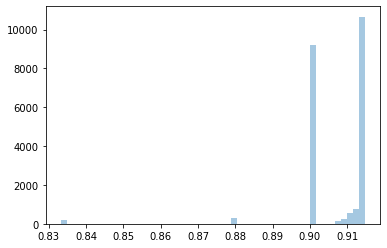

In [0]:
sns.distplot(rf_model2.predict(lgd_test.iloc[:,1:]), kde=False)

In [0]:
# Model 3, max_features = 15
lgd_rf3 = RandomForestRegressor(n_estimators=1000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. # Wee let it gro as big as it can
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=15, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       )

In [0]:
#Model 3
rf_model3 = lgd_rf3.fit(lgd_train.iloc[:, 1:], lgd_train['lgd'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.6min finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


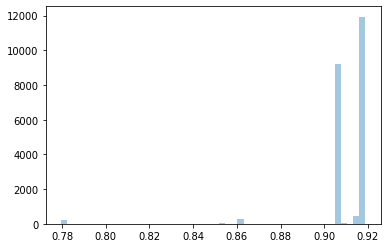

In [0]:
sns.distplot(rf_model3.predict(lgd_test.iloc[:,1:]), kde=False)

In [0]:
# Model 4 max_features = 5
lgd_rf4 = RandomForestRegressor(n_estimators=1000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. # Wee let it gro as big as it can
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features=5, # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       )

In [0]:
#Model 4
rf_model4 = lgd_rf4.fit(lgd_train.iloc[:, 1:], lgd_train['lgd'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.5s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


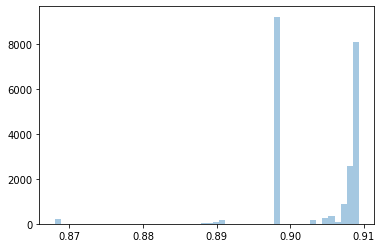

In [0]:
sns.distplot(rf_model4.predict(lgd_test.iloc[:,1:]), kde=False)

In [0]:
import pickle

In [0]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))
 
# some time later...

In [0]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))


In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [0]:
#print('Mean Squared Error Testing Model 1:', mean_squared_error(lgd_test.lgd, rf_model.predict(lgd_test.iloc[:,1:])))
print('Mean Squared Error Testing Model 2:', mean_squared_error(lgd_test.lgd, rf_model2.predict(lgd_test.iloc[:,1:])))
print('Mean Squared Error Testing Model 3:', mean_squared_error(lgd_test.lgd, rf_model3.predict(lgd_test.iloc[:,1:])))
print('Mean Squared Error Testing Model 4:', mean_squared_error(lgd_test.lgd, rf_model4.predict(lgd_test.iloc[:,1:])))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


Mean Squared Error Testing Model 2: 0.009850609150595779


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Mean Squared Error Testing Model 3: 0.009490086168569337


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s


Mean Squared Error Testing Model 4: 0.010411853094687243


[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [0]:
# Finding the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [0]:
rf_model = Pipeline([
    ('Normalizer', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=1000, # Number of trees to train
                       criterion='mse', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change. # Wee let it gro as big as it can
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251082976, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       ))   
])


In [0]:
param_grid = dict(
                  rf__max_features=[5,10,15])

grid = GridSearchCV(rf_model, param_grid, cv=5,
                    scoring=make_scorer(mean_absolute_error), n_jobs=-1)

In [0]:
cv_grid = cross_val_score(grid, lgd_train.iloc[:,1:], lgd_train.lgd, 
                            cv = 5, n_jobs=-1)

Looking at the performance using cross validation

In [0]:
cv_rf = cross_val_score(lgd_rf, lgd_train.iloc[:,1:], lgd_train.lgd, 
                            cv = 5, n_jobs=-1)

In [0]:
cv_rf.mean()

0.18181119472819568

In [0]:
# CV using the second model 
cv_rf2 = cross_val_score(lgd_rf2, lgd_train.iloc[:,1:], lgd_train.lgd, 
                            cv = 5, n_jobs=-1)

In [0]:
cv_rf2.mean()

0.11679207492708717

In [0]:
cv_rf3 = cross_val_score(lgd_rf3, lgd_train.iloc[:,1:], lgd_train.lgd, 
                            cv = 5, n_jobs=-1)

In [0]:
cv_rf3.mean()

0.14872665600091067

In [0]:
cv_rf4 = cross_val_score(lgd_rf4, lgd_train.iloc[:,1:], lgd_train.lgd, 
                            cv = 5, n_jobs=-1)

In [0]:
cv_rf4.mean()

0.06264121672227371

The chosen model for RF will be model 2. 


In [0]:
rf_pred_regress = lgd_rf2.predict(lgd_test.iloc[:,1:])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


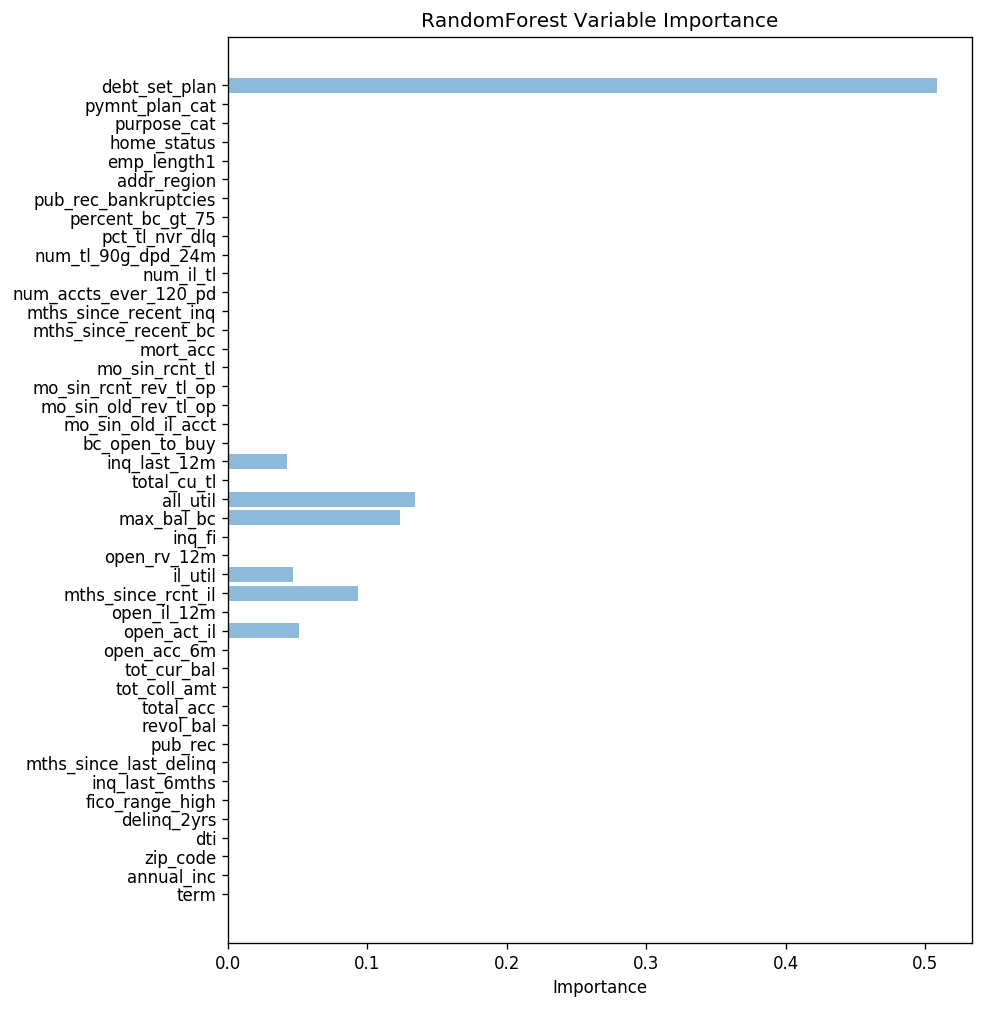

In [0]:
plt.figure(dpi=120, figsize=(8,10))
plt.barh(lgd_train.columns[1:], lgd_rf2.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(lgd_train.columns[1:])
plt.xlabel('Importance')
plt.title('RandomForest Variable Importance')
plt.show()

## XGBoosting

In [0]:
lgd_xgb = GradientBoostingRegressor(loss='ls', # How to calculate losses. Deviance is for probabilistic outputs. Alternative exponential for AdaBoost. 
                           learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=1000, # How many trees to use, the more the better, but decrease learning rate if many used.
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # Minimum samples for a split.
                           min_samples_leaf=75, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=3, # Maximum depth. Keep it small!
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=251082976, # Seed
                           max_features='auto', # Same as RF. 
                           verbose=1,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, # XGBoost CAN overfit, so control this just in case. Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )

In [0]:
model_xg = lgd_xg.fit(lgd_train.iloc[:, 1:], lgd_train['lgd'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0122           0.0005           11.78m
         2           0.0117           0.0004           11.10m
         3           0.0114           0.0003           10.53m
         4           0.0113           0.0003           10.30m
         5           0.0109           0.0002           10.12m
         6           0.0107           0.0002           10.02m
         7           0.0106           0.0001            9.97m
         8           0.0105           0.0001            9.90m
         9           0.0104           0.0001            9.99m
        10           0.0103           0.0001           10.15m
        20           0.0100           0.0000           10.14m
        30           0.0100           0.0000           10.14m
        40           0.0100           0.0000           10.15m
        50           0.0099           0.0000           10.19m
        60           0.0098           0.0000           10.29m
       

In [0]:
lgd_xgb2 = GradientBoostingRegressor(loss='ls', # How to calculate losses. Deviance is for probabilistic outputs. Alternative exponential for AdaBoost. 
                           learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=1000, # How many trees to use, the more the better, but decrease learning rate if many used.
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # Minimum samples for a split.
                           min_samples_leaf=75, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=2, # Maximum depth. Keep it small!
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=251082976, # Seed
                           max_features='auto', # Same as RF. 
                           verbose=1,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, # XGBoost CAN overfit, so control this just in case. Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )

In [0]:
model_xg2 = lgd_xgb2.fit(lgd_train.iloc[:, 1:], lgd_train['lgd'])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0122           0.0005            6.01m
         2           0.0118           0.0004            6.04m
         3           0.0115           0.0003            6.02m
         4           0.0113           0.0003            6.01m
         5           0.0109           0.0002            6.00m
         6           0.0108           0.0002            5.98m
         7           0.0107           0.0001            5.97m
         8           0.0106           0.0001            5.94m
         9           0.0105           0.0001            5.94m
        10           0.0104           0.0001            5.94m
        20           0.0100           0.0000            5.83m
        30           0.0101           0.0000            5.69m
        40           0.0101           0.0000            5.63m
        50           0.0100           0.0000            5.59m
        60           0.0099           0.0000            5.52m
       

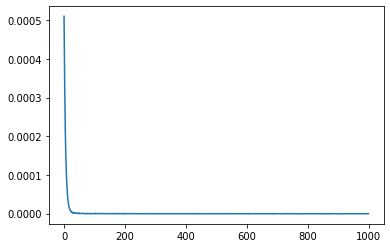

In [0]:
plt.plot(model_xg.oob_improvement_)

In [0]:
xg_pred_regr_test = model_xg.predict(lgd_test.iloc[:, 1:])

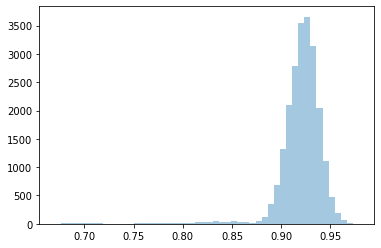

In [0]:
sns.distplot(model_xg.predict(lgd_test.iloc[:, 1:]), kde=False)

In [0]:
xg_pred_regr_test

array([0.91466103, 0.92376514, 0.93267266, ..., 0.91218   , 0.92897913,
       0.933283  ])

In [0]:
pd.DataFrame(model_xg.feature_importances_, index = lgd_test.iloc[:,1:].columns)

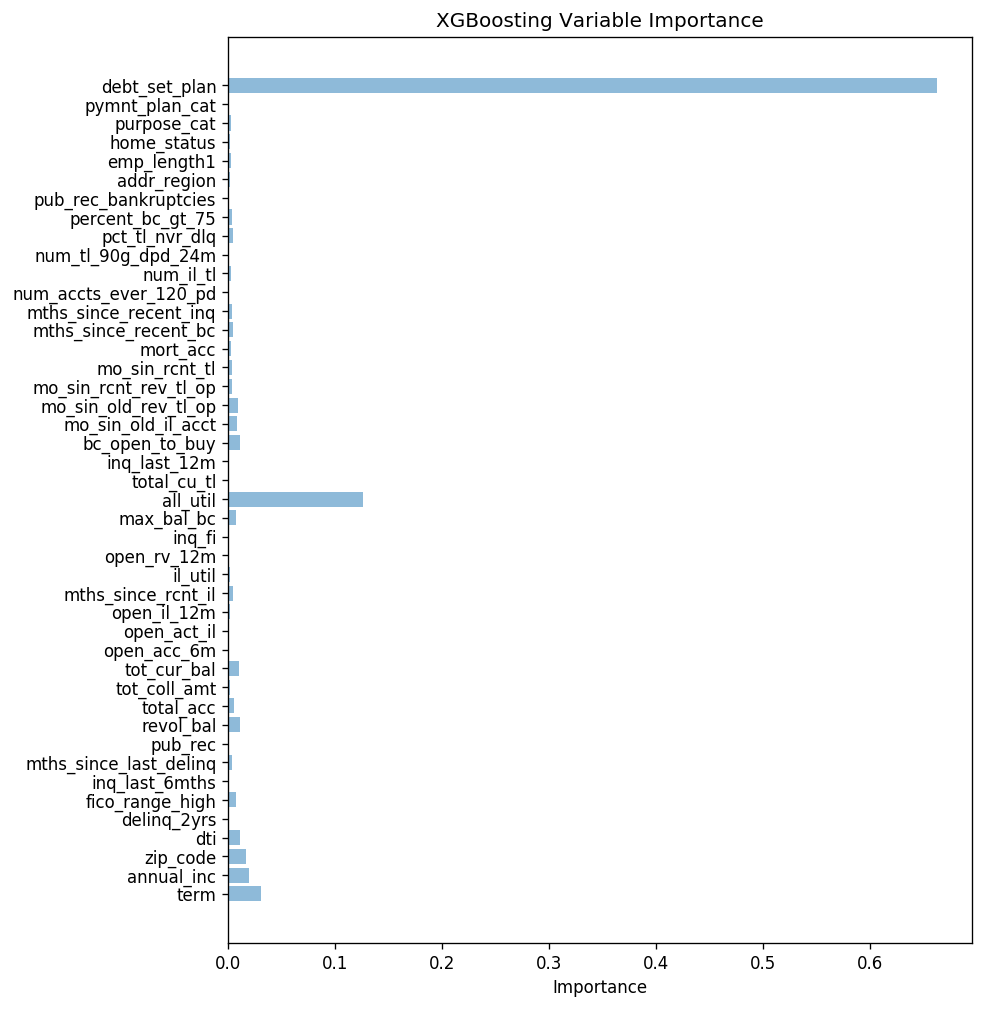

In [0]:
plt.figure(dpi=120, figsize=(8,10))
plt.barh(lgd_train.columns[1:], model_xg.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(lgd_train.columns[1:])
plt.xlabel('Importance')
plt.title('XGBoosting Variable Importance')
plt.show()

In [0]:
plt.figure(dpi=120, figsize=(8,10))
plt.barh(lgd_train.columns[1:], model_xg2.feature_importances_,
        align='center', alpha=0.5)
plt.yticks(lgd_train.columns[1:])
plt.xlabel('Importance')
plt.title('XGBoosting Variable Importance')
plt.show()

MSE over the test set 

In [0]:
print('Mean Squared Error XGB:', mean_squared_error(lgd_test.lgd,  model_xg.predict(lgd_test.iloc[:, 1:])))

Mean Squared Error XGB: 0.00833229361586412
